In [1]:
# C:\Mark\uni\Uni Work\5th Year\Diss\ROC Surfaces\adni_noNA.csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib notebook

# The data

In [2]:
df = pd.read_csv('C:\\Mark\\uni\\Uni Work\\5th Year\\Diss\\ROC Surfaces\\adni_noNA.csv')
df['gender_recoded'] = df['gender']-1
df

,Unnamed: 0,RID,APOE4,MMSE,age,gender,educ,DX,abeta,tau,LeftHipp,RightHipp,Hipp,HCI,gender_recoded
0,1,2002,0,28,65,1,16,2,293,254,3.919,4.041,7.960,8.5163,0
1,2,2002,0,28,65,1,16,2,293,254,3.803,4.033,7.836,8.5163,0
2,3,2010,1,30,63,2,20,2,444,729,4.045,3.957,8.002,4.9071,1
3,4,2010,1,30,63,2,20,2,444,729,4.001,4.003,8.004,4.9071,1
4,5,2018,0,29,76,2,18,2,500,559,3.789,3.965,7.754,8.7040,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1030,5290,1,29,67,2,12,1,1808,1620,3.782,3.759,7.541,4.9309,1
1028,1031,5292,0,30,74,2,13,1,1850,1330,3.397,3.705,7.102,6.8485,1
1029,1032,5295,1,29,75,2,15,1,802,1792,2.657,3.271,5.928,18.9298,1
1030,1033,5296,0,29,69,1,14,1,270,569,5.140,5.392,10.532,10.1158,0


In [3]:
d1 = df[df['DX'] == 1]
d2 = df[df['DX'] == 2]
d3 = df[df['DX'] == 3]

In [4]:
def ROCSurfaceEmp(d1, d2, d3, marker, reverse=False, log=False):
    marker_1 = np.array(d1[marker])
    marker_2 = np.array(d2[marker])
    marker_3 = np.array(d3[marker])
    
    if log:
        marker_1 = np.log(marker_1)
        marker_2 = np.log(marker_2)
        marker_3 = np.log(marker_3)
    
    if reverse:
        marker_1 = [-i for i in marker_1]
        marker_2 = [-i for i in marker_2]
        marker_3 = [-i for i in marker_3]
    
    mu1d, sigma1d = np.mean(marker_1), np.std(marker_1)
    mu2d, sigma2d = np.mean(marker_2), np.std(marker_2)
    mu3d, sigma3d = np.mean(marker_3), np.std(marker_3)
    
    p1 = np.linspace(0,1,100)
    p3 = np.linspace(0,1,100)

    a = (mu3d - mu2d) / sigma2d
    b = sigma3d / sigma2d

    c = (mu1d - mu2d) / sigma2d
    d = sigma1d / sigma2d
    
    ecdf = ECDF(marker_2) 

    ROCsurface = []
    ROCsurface2 = []

    for i in p1:
        nowlist = []
        nowlist2 = []
        for j in p3:
            rocsurface_here = ecdf(np.quantile(marker_3, 1-j)) - ecdf(np.quantile(marker_1, i))

            if rocsurface_here >=0:
                nowlist.append(rocsurface_here)
                nowlist2.append(rocsurface_here)
            else:
                nowlist.append(0)
                nowlist2.append(np.nan)
        ROCsurface.append(nowlist)
        ROCsurface2.append(nowlist2)
        
    first = [ROCsurface[i][j] for i in range(100) for j in range(100)]
    VUS = np.nanmean(first)
    
    #ROCsurface2 = [np.nan if i == 0 else i for i in ROCsurface[j] for j in range(100)]
    
    return p1, ROCsurface, p3, VUS, ROCsurface2

In [21]:
ratio = 7.5/5.3
print(ratio*6.5)

9.19811320754717


# Covariates - Age and Gender

First we must investigate the data

In [5]:
marker = 'HCI'
cov1 = 'age'
cov2 = 'gender_recoded'

### Linear Models

In [6]:
from sklearn.linear_model import LinearRegression

# Pick out only the marker values
d1_marker = np.array(d1[marker])
d2_marker = np.array(d2[marker])
d3_marker = np.array(d3[marker])

# Pick out only the ages
d1_age= np.array(d1[cov1])
d2_age= np.array(d2[cov1])
d3_age= np.array(d3[cov1])

# Pick out only the gender (recoded to 0 for men and 1 for women)
d1_gender= np.array(d1[cov2])
d2_gender= np.array(d2[cov2])
d3_gender= np.array(d3[cov2])

# Reshape the data to work with sklearn
d1_age = d1_age.reshape(-1, 1)
d1_marker = d1_marker.reshape(-1, 1)
d1_gender = d1_gender.reshape(-1, 1)

d2_age = d2_age.reshape(-1, 1)
d2_marker = d2_marker.reshape(-1, 1)
d2_gender = d2_gender.reshape(-1, 1)

d3_age = d3_age.reshape(-1, 1)
d3_marker = d3_marker.reshape(-1, 1)
d3_gender = d3_gender.reshape(-1, 1)

X1 = np.array([[d1_age[i][0], d1_gender[i][0]] for i in range(len(d1_marker))])
X2 = np.array([[d2_age[i][0], d2_gender[i][0]] for i in range(len(d2_marker))])
X3 = np.array([[d3_age[i][0], d3_gender[i][0]] for i in range(len(d3_marker))])

pred_array1 = ([[i, 0] for i in np.arange(50,91)])
pred_array2 = ([[i, 1] for i in np.arange(50,91)])
pred_array = np.array(pred_array1 + pred_array2)

# Fit the linear model and find the parameters and the standard residual error for healthy
regd1 = LinearRegression().fit(X1, d1_marker)
beta1 = [regd1.intercept_[0], regd1.coef_[0][0], regd1.coef_[0][1]]
# Calculate sigma hat
yd1_hat = regd1.predict(X1)
residualsd1 = d1_marker - yd1_hat
residual_sum_of_squaresd1 = residualsd1.T @ residualsd1
sigmad1 = np.sqrt(residual_sum_of_squaresd1/(len(d1_marker)-2))
sigmad1 = sigmad1[0][0]

# Fit the linear model and find the parameters and the standard residual error for healthy
regd2 = LinearRegression().fit(X2, d2_marker)
beta2 = [regd2.intercept_[0], regd2.coef_[0][0], regd2.coef_[0][1]]
# Calculate sigma hat
yd2_hat = regd2.predict(X2)
residualsd2 = d2_marker - yd2_hat
residual_sum_of_squaresd2 = residualsd2.T @ residualsd2
sigmad2 = np.sqrt(residual_sum_of_squaresd2/(len(d2_marker)-2))
sigmad2 = sigmad2[0][0]

# Fit the linear model and find the parameters and the standard residual error for healthy
regd3 = LinearRegression().fit(X3, d3_marker)
beta3 = [regd3.intercept_[0], regd3.coef_[0][0], regd3.coef_[0][1]]
# Calculate sigma hat
yd3_hat = regd3.predict(X3)
residualsd3 = d3_marker - yd3_hat
residual_sum_of_squaresd3 = residualsd3.T @ residualsd3
sigmad3 = np.sqrt(residual_sum_of_squaresd3/(len(d3_marker)-2))
sigmad3 = sigmad3[0][0]

#### Residuals

<IPython.core.display.Javascript object>


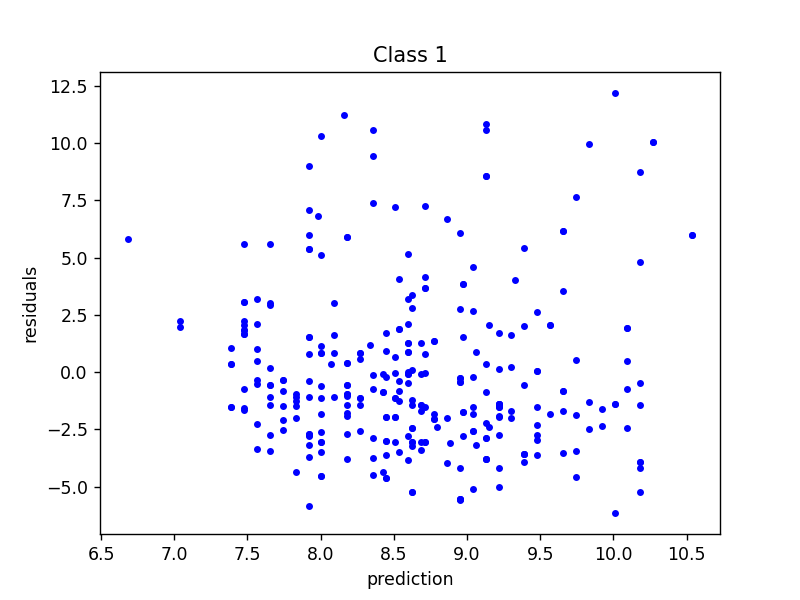

<IPython.core.display.Javascript object>


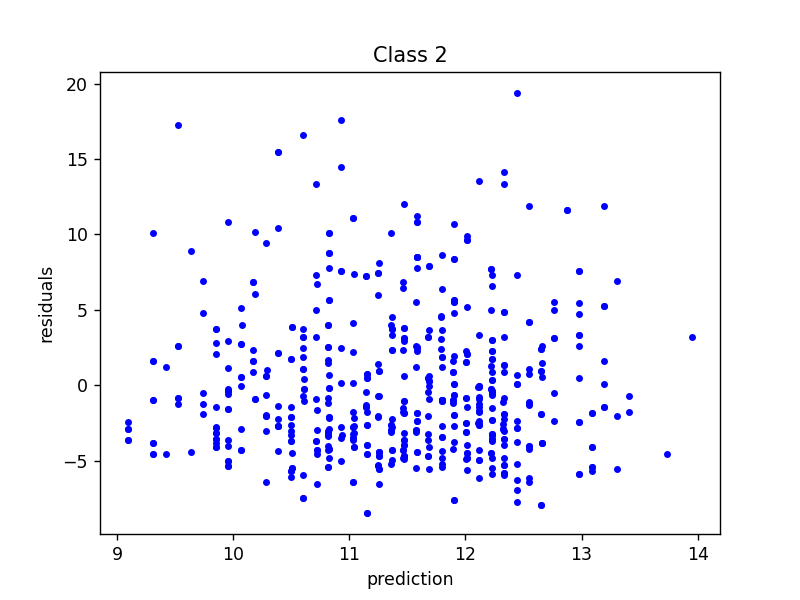

<IPython.core.display.Javascript object>


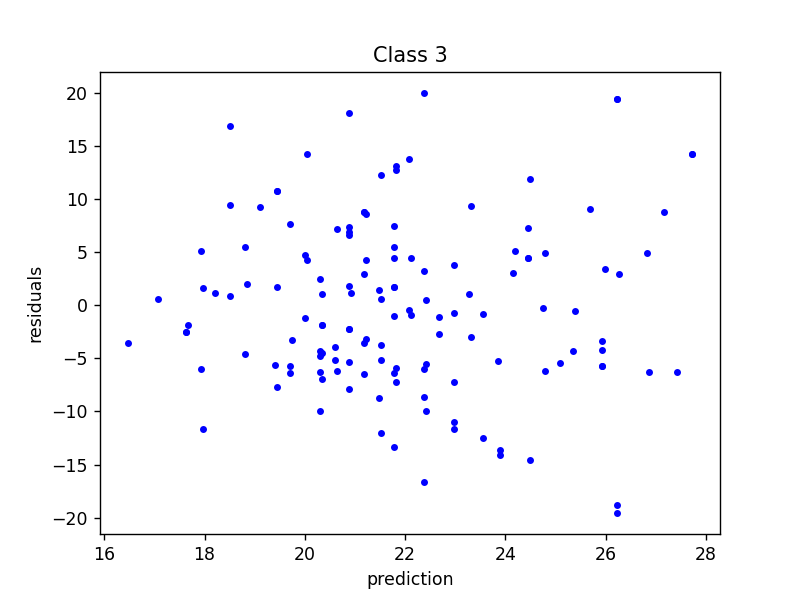

In [7]:
plt.figure()
plt.plot(yd1_hat,residualsd1, 'b.')
plt.title('Class 1')
plt.ylabel('residuals')
plt.xlabel('prediction')
plt.show()

plt.figure()
plt.plot(yd2_hat,residualsd2, 'b.')
plt.title('Class 2')
plt.ylabel('residuals')
plt.xlabel('prediction')
plt.show()

plt.figure()
plt.plot(yd3_hat,residualsd3, 'b.')
plt.title('Class 3')
plt.ylabel('residuals')
plt.xlabel('prediction')
plt.show()

### Covariate ROC Surfaces

In [8]:
gridsize=30

p1 = np.linspace(0,1,gridsize)
p3 = np.linspace(0,1,gridsize)

age_grid = np.arange(55,91)
gender = [0,1]

Xpred = np.array([[1, i, j] for i in np.arange(55,91) for j in [0,1]])

mu1_pred = Xpred @ np.array(beta1)
mu2_pred = Xpred @ np.array(beta2)
mu3_pred = Xpred @ np.array(beta3)

roc_age_est = {}
vus_age_est = {}

# Fit the ECDF to the standardised residuals of the diseased population
ecdf = ECDF([i[0] for i in residualsd2/sigmad2])

for k in range(len(age_grid)):
    for l in gender:
        
        if k == 0 and l == 0:
            index = 0        
        elif l == 0:
            index = 2*k
        elif l == 1:
            index = 2*k + 1
        
        a = (mu3_pred[index] - mu2_pred[index]) / sigmad2
        b = sigmad3 / sigmad3

        c = (mu1_pred[index] - mu2_pred[index]) / sigmad2
        d = sigmad3 / sigmad2

        ROC_surface = []

        for i in p1:
            nowlist = []
            for j in p3:
                roc_now = ecdf(a + b*np.quantile(residualsd3/sigmad3, 1-j)) - ecdf(c+d*np.quantile(residualsd1/sigmad1, i))

                if roc_now >= 0:
                    nowlist.append(roc_now)
                else:
                    nowlist.append(0)

            ROC_surface.append(nowlist)

        first = [ROC_surface[i][j] for i in range(gridsize) for j in range(gridsize)]
        VUS = np.nanmean(first)

        roc_age_est[f'Gender: {l}. Age: {k+55}'] = ROC_surface
        vus_age_est[f'Gender: {l}. Age: {k+55}'] = VUS
        print(f'Gender: {l}. Age: {k+55}')

Gender: 0. Age: 55
Gender: 1. Age: 55
Gender: 0. Age: 56
Gender: 1. Age: 56
Gender: 0. Age: 57
Gender: 1. Age: 57
Gender: 0. Age: 58
Gender: 1. Age: 58
Gender: 0. Age: 59
Gender: 1. Age: 59
Gender: 0. Age: 60
Gender: 1. Age: 60
Gender: 0. Age: 61
Gender: 1. Age: 61
Gender: 0. Age: 62
Gender: 1. Age: 62
Gender: 0. Age: 63
Gender: 1. Age: 63
Gender: 0. Age: 64
Gender: 1. Age: 64
Gender: 0. Age: 65
Gender: 1. Age: 65
Gender: 0. Age: 66
Gender: 1. Age: 66
Gender: 0. Age: 67
Gender: 1. Age: 67
Gender: 0. Age: 68
Gender: 1. Age: 68
Gender: 0. Age: 69
Gender: 1. Age: 69
Gender: 0. Age: 70
Gender: 1. Age: 70
Gender: 0. Age: 71
Gender: 1. Age: 71
Gender: 0. Age: 72
Gender: 1. Age: 72
Gender: 0. Age: 73
Gender: 1. Age: 73
Gender: 0. Age: 74
Gender: 1. Age: 74
Gender: 0. Age: 75
Gender: 1. Age: 75
Gender: 0. Age: 76
Gender: 1. Age: 76
Gender: 0. Age: 77
Gender: 1. Age: 77
Gender: 0. Age: 78
Gender: 1. Age: 78
Gender: 0. Age: 79
Gender: 1. Age: 79
Gender: 0. Age: 80
Gender: 1. Age: 80
Gender: 0. A

In [9]:
#roc_age_est.keys()
VUSs = [i for i in (vus_age_est.values())]
male_VUSs = VUSs[::2]    # Even rows are male
female_VUSs = VUSs[1::2] # Odd rows are female
#age_grid

<IPython.core.display.Javascript object>


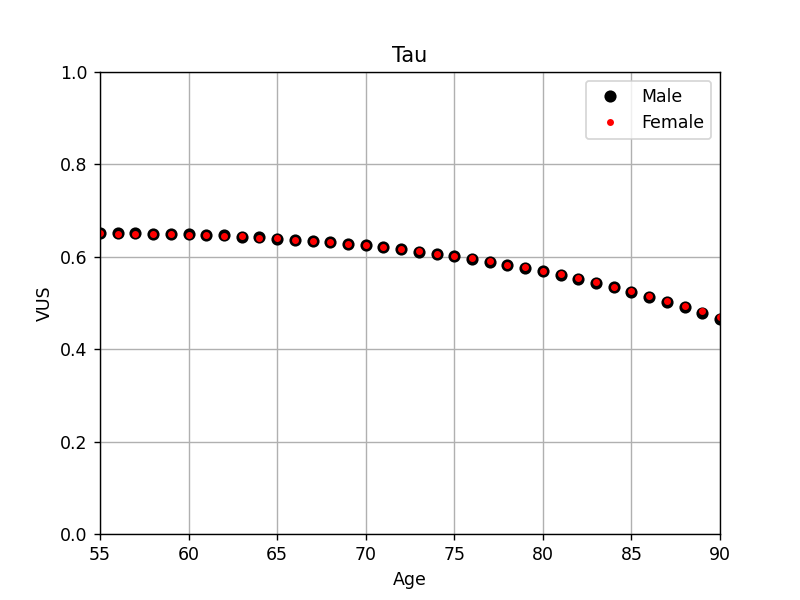

In [13]:
plt.figure()
plt.plot(age_grid, male_VUSs, 'ko', label='Male')
plt.ylim(0,1)
plt.xlim(55,90)
plt.title('Tau')
plt.xlabel('Age')
plt.ylabel('VUS')
plt.grid(visible=True)
plt.plot(age_grid, female_VUSs, 'r.', label='Female')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


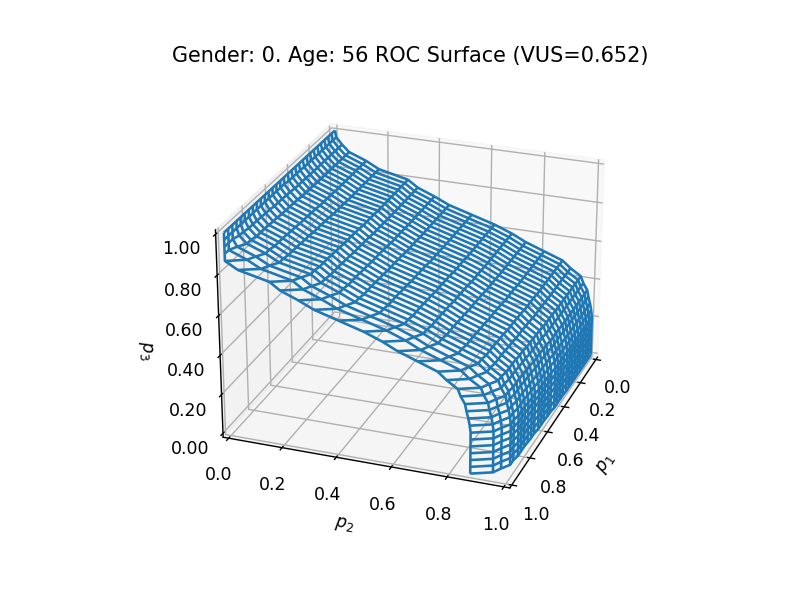

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

p1 = np.linspace(0,1,gridsize)
p3 = np.linspace(0,1,gridsize)

age = 'Gender: 0. Age: 56'
roc_age_est[age]

x, z = np.meshgrid(p1, p3)

surf = ax.plot_wireframe(x, roc_age_est[age], z, rstride=1, cstride=1)

ax.zaxis.set_major_formatter('{x:.02f}')

ax.set_title(f"{age} ROC Surface (VUS={round(vus_age_est[age], 3)})")

ax.set_xlabel("$p_1$")
ax.set_xlim(0,1)

ax.set_ylabel("$p_2$")
ax.set_ylim(0,1)

ax.set_zlabel("$p_3$")
ax.set_zlim(0,1)

ax.view_init(elev=25, azim=20)

plt.show()

# Bootstrap 

## Coding Bootstrap

In [17]:
"""
BOOTSTRAPPING BELOW
"""

df = pd.read_csv('C:\\Mark\\uni\\Uni Work\\5th Year\\Diss\\ROC Surfaces\\adni_noNA.csv')
df['gender_recoded'] = df['gender']-1
data_len = df.shape[0]

VUSs = []
ROCs = []

gridsize = 25
bootstrapsize = 500

for counter in range(bootstrapsize):
    rdf = df.sample(n=data_len, replace=True)
    
    d1 = rdf[rdf['DX'] == 1]
    d2 = rdf[rdf['DX'] == 2]
    d3 = rdf[rdf['DX'] == 3]

    # Pick out only the marker values
    d1_marker = np.array(d1[marker])
    d2_marker = np.array(d2[marker])
    d3_marker = np.array(d3[marker])

    # Pick out only the ages
    d1_age= np.array(d1[cov1])
    d2_age= np.array(d2[cov1])
    d3_age= np.array(d3[cov1])

    # Pick out only the gender (recoded to 0 for men and 1 for women)
    d1_gender= np.array(d1[cov2])
    d2_gender= np.array(d2[cov2])
    d3_gender= np.array(d3[cov2])

    # Reshape the data to work with sklearn
    d1_age = d1_age.reshape(-1, 1)
    d1_marker = d1_marker.reshape(-1, 1)
    d1_gender = d1_gender.reshape(-1, 1)

    d2_age = d2_age.reshape(-1, 1)
    d2_marker = d2_marker.reshape(-1, 1)
    d2_gender = d2_gender.reshape(-1, 1)

    d3_age = d3_age.reshape(-1, 1)
    d3_marker = d3_marker.reshape(-1, 1)
    d3_gender = d3_gender.reshape(-1, 1)

    X1 = np.array([[d1_age[i][0], d1_gender[i][0]] for i in range(len(d1_marker))])
    X2 = np.array([[d2_age[i][0], d2_gender[i][0]] for i in range(len(d2_marker))])
    X3 = np.array([[d3_age[i][0], d3_gender[i][0]] for i in range(len(d3_marker))])

    pred_array1 = ([[i, 0] for i in np.arange(50,91)])
    pred_array2 = ([[i, 1] for i in np.arange(50,91)])
    pred_array = np.array(pred_array1 + pred_array2)

    # Fit the linear model and find the parameters and the standard residual error for healthy
    regd1 = LinearRegression().fit(X1, d1_marker)
    beta1 = [regd1.intercept_[0], regd1.coef_[0][0], regd1.coef_[0][1]]
    # Calculate sigma hat
    yd1_hat = regd1.predict(X1)
    residualsd1 = d1_marker - yd1_hat
    residual_sum_of_squaresd1 = residualsd1.T @ residualsd1
    sigmad1 = np.sqrt(residual_sum_of_squaresd1/(len(d1_marker)-2))
    sigmad1 = sigmad1[0][0]

    # Fit the linear model and find the parameters and the standard residual error for healthy
    regd2 = LinearRegression().fit(X2, d2_marker)
    beta2 = [regd2.intercept_[0], regd2.coef_[0][0], regd2.coef_[0][1]]
    # Calculate sigma hat
    yd2_hat = regd2.predict(X2)
    residualsd2 = d2_marker - yd2_hat
    residual_sum_of_squaresd2 = residualsd2.T @ residualsd2
    sigmad2 = np.sqrt(residual_sum_of_squaresd2/(len(d2_marker)-2))
    sigmad2 = sigmad2[0][0]

    # Fit the linear model and find the parameters and the standard residual error for healthy
    regd3 = LinearRegression().fit(X3, d3_marker)
    beta3 = [regd3.intercept_[0], regd3.coef_[0][0], regd3.coef_[0][1]]
    # Calculate sigma hat
    yd3_hat = regd3.predict(X3)
    residualsd3 = d3_marker - yd3_hat
    residual_sum_of_squaresd3 = residualsd3.T @ residualsd3
    sigmad3 = np.sqrt(residual_sum_of_squaresd3/(len(d3_marker)-2))
    sigmad3 = sigmad3[0][0]
    
    gridsize=30

    p1 = np.linspace(0,1,gridsize)
    p3 = np.linspace(0,1,gridsize)

    age_grid = np.arange(55,91)
    gender = [0,1]

    Xpred = np.array([[1, i, j] for i in np.arange(55,91) for j in [0,1]])

    mu1_pred = Xpred @ np.array(beta1)
    mu2_pred = Xpred @ np.array(beta2)
    mu3_pred = Xpred @ np.array(beta3)

    #roc_age_est = {}
    vus_age_est = {}

    # Fit the ECDF to the standardised residuals of the diseased population
    ecdf = ECDF([i[0] for i in residualsd2/sigmad2])

    for k in range(len(age_grid)):
        for l in gender:

            if k == 0 and l == 0:
                index = 0        
            elif l == 0:
                index = 2*k
            elif l == 1:
                index = 2*k + 1

            a = (mu3_pred[index] - mu2_pred[index]) / sigmad2
            b = sigmad3 / sigmad3

            c = (mu1_pred[index] - mu2_pred[index]) / sigmad2
            d = sigmad3 / sigmad2

            ROC_surface = []

            for i in p1:
                nowlist = []
                for j in p3:
                    roc_now = ecdf(a + b*np.quantile(residualsd3/sigmad3, 1-j)) - ecdf(c+d*np.quantile(residualsd1/sigmad1, i))

                    if roc_now >= 0:
                        nowlist.append(roc_now)
                    else:
                        nowlist.append(0)

                ROC_surface.append(nowlist)

            first = [ROC_surface[i][j] for i in range(gridsize) for j in range(gridsize)]
            VUS = np.nanmean(first)

            #roc_age_est[f'Gender: {l}. Age: {k+55}'] = ROC_surface
            vus_age_est[f'Gender: {l}. Age: {k+55}'] = VUS
            
    #ROCs.append(roc_age_est)
    VUSs.append(vus_age_est)
        
    if counter % 10 == 0:
        print(counter)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


## Plotting Bootstrap

<IPython.core.display.Javascript object>


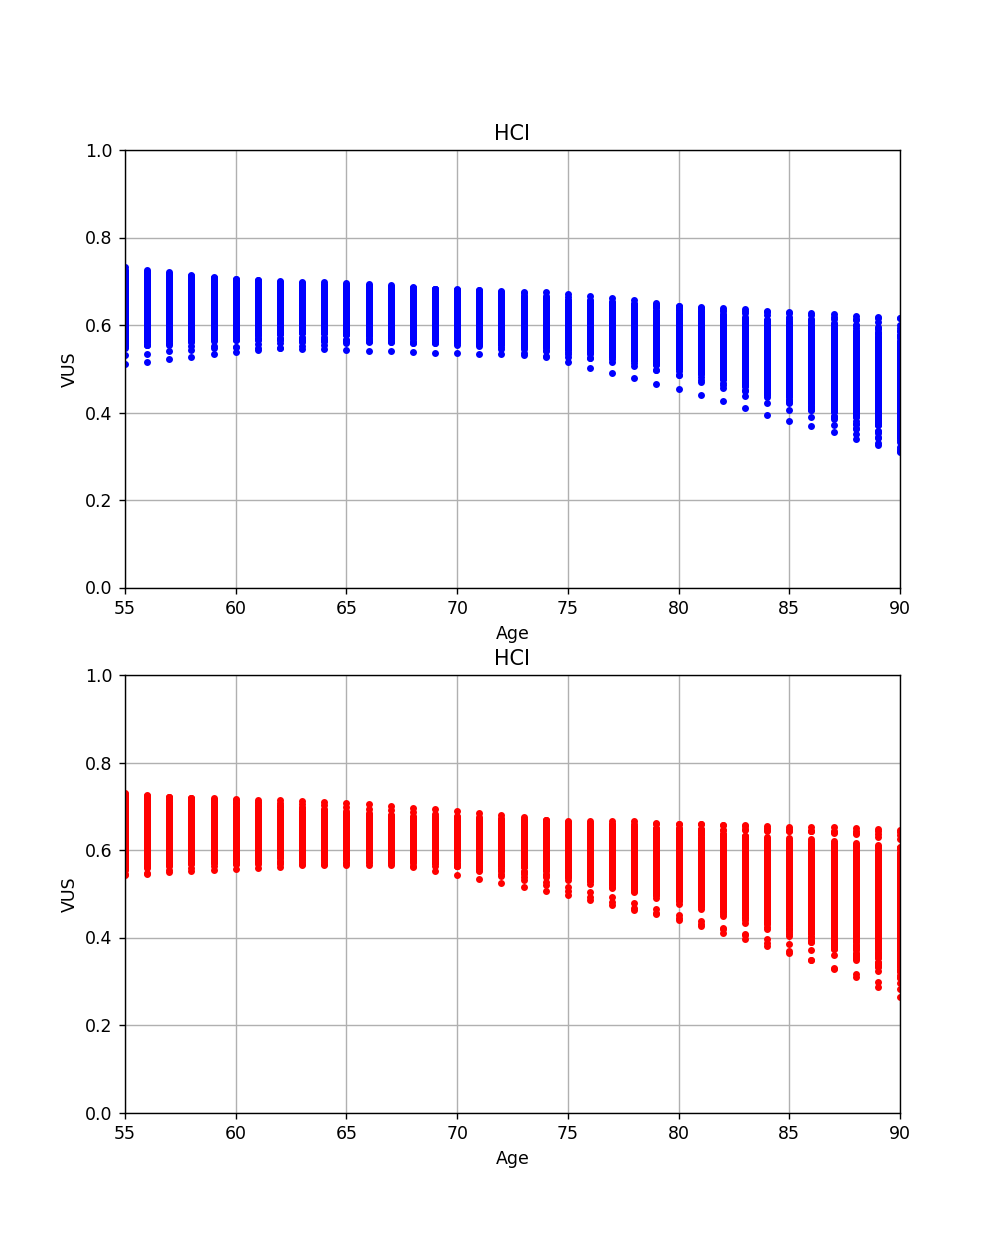

In [18]:
male_keys = [f'Gender: 0. Age: {i}' for i in np.arange(55,91)]
female_keys = [f'Gender: 1. Age: {i}' for i in np.arange(55,91)]

fig, ax = plt.subplots(2,1, figsize=(8,10))

for i in VUSs:
    toplotmale = {your_key : i[your_key] for your_key in male_keys}
    toplotfemale = {your_key : i[your_key] for your_key in female_keys}
    
    ax[0].plot(age_grid, toplotmale.values(), 'b.')
    ax[1].plot(age_grid, toplotfemale.values(), 'r.')
    
for i in ax:
    i.set_ylim(0,1)
    i.set_xlim(55,90)
    i.set_title(marker)
    i.grid()
    i.set_xlabel('Age')
    i.set_ylabel('VUS')

plt.grid(visible=True)
plt.show()

<IPython.core.display.Javascript object>


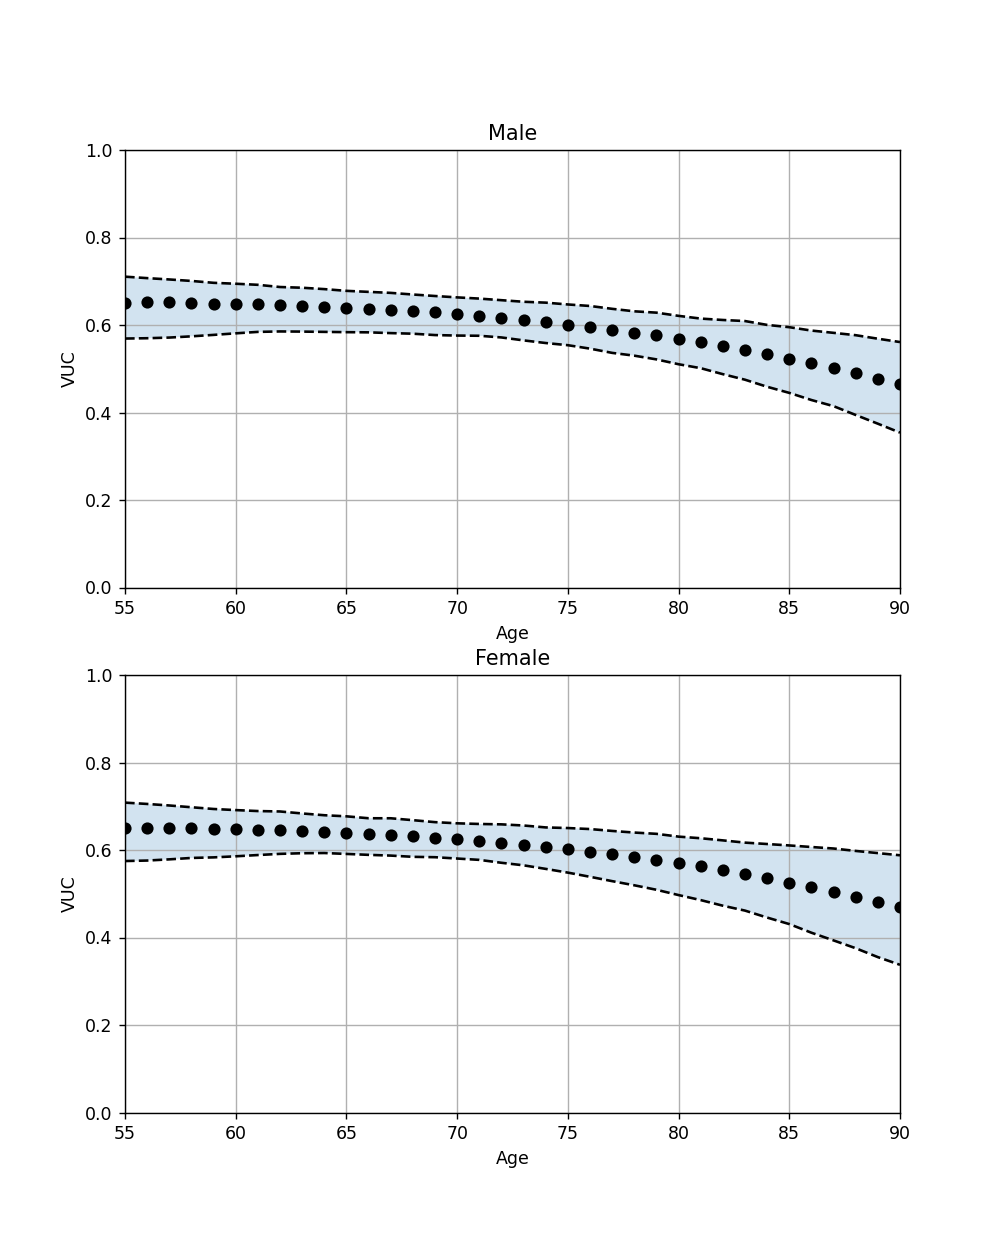

In [19]:
fig, ax = plt.subplots(2,1, figsize=(8,10))

"""
Male section below here, the code to calculate the quantiles of the VUS

"""

male_keys = [f'Gender: 0. Age: {i}' for i in np.arange(55,91)]

mVUC975s = []
mVUC25s = []
VUSs_now = []

for i in male_keys:
    VUSs_now = []
    for j in VUSs:
        VUSs_now.append(j[i])
        
    mVUC975 = stats.mstats.mquantiles(VUSs_now, 0.975)
    mVUC25 = stats.mstats.mquantiles(VUSs_now, 0.025)

    mVUC975s.append(mVUC975)
    mVUC25s.append(mVUC25)

mVUC25s = [i[0] for i in mVUC25s]
mVUC975s = [i[0] for i in mVUC975s]

"""
Female section below here, the code to calculate the quantiles of the VUS

"""
female_keys = [f'Gender: 1. Age: {i}' for i in np.arange(55,91)]

fVUC975s = []
fVUC25s = []
VUSs_now = []

for i in female_keys:
    VUSs_now = []
    for j in VUSs:
        VUSs_now.append(j[i])
        
    fVUC975 = stats.mstats.mquantiles(VUSs_now, 0.975)
    fVUC25 = stats.mstats.mquantiles(VUSs_now, 0.025)

    fVUC975s.append(fVUC975)
    fVUC25s.append(fVUC25)

fVUC25s = [i[0] for i in fVUC25s]
fVUC975s = [i[0] for i in fVUC975s]


"""
Plotting

"""

ax[0].set_title('Male')
ax[0].plot(age_grid, mVUC975s, 'k--')
ax[0].plot(age_grid, mVUC25s, 'k--')
ax[0].fill_between(age_grid, mVUC25s, mVUC975s, alpha=0.2)
ax[0].plot(age_grid, male_VUSs, 'ko', label='Male')

ax[1].set_title('Female')
ax[1].plot(age_grid, fVUC975s, 'k--')
ax[1].plot(age_grid, fVUC25s, 'k--')
ax[1].fill_between(age_grid, fVUC25s, fVUC975s, alpha=0.2)
ax[1].plot(age_grid, female_VUSs, 'ko', label='Female')

for i in ax:
    i.grid()
    i.set_xlim(55,90)
    i.set_xlabel('Age')
    i.set_ylabel('VUC')
    i.set_ylim(0,1)
plt.show()